In [1]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import models


In [11]:
class ArchedEyebrowsDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.annotations = pd.read_csv(csv_file)  # Load the CSV file
        self.img_dir = img_dir                   # Directory containing images
        self.transform = transform               # Transformations (resize, normalize, etc.)
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        # Get image id and "Arched_Eyebrows" label from CSV
        img_id = self.annotations.iloc[idx, 0]          # Assuming the image ID is in the first column
        img_name = os.path.join(self.img_dir, img_id)   # Construct the image file path
        image = Image.open(img_name)                    # Load the image
        
        # Extract the "Arched_Eyebrows" label, assuming it's in the column named "Arched_Eyebrows"
        label = self.annotations.iloc[idx]["Arched_Eyebrows"]
        label = 1 if label == 1 else 0  # Convert label to binary (0 or 1)
        
        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)
        
        return image, label


# Define the data transformations (resize and normalize)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create an instance of the dataset
dataset = ArchedEyebrowsDataset(csv_file='face_image_attr.csv', img_dir='img_align_celeba', transform=data_transforms)

# Create a DataLoader
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)


In [20]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class SubsetEyebrowsDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.annotations = pd.read_csv(csv_file)  # Load the full CSV file
        self.img_dir = img_dir                   # Directory containing the subset of images
        self.transform = transform               # Any image transformations

        # Filter the annotations to include only available images
        self.available_annotations = self.annotations[self.annotations['image_id'].apply(self.image_exists)]

    def image_exists(self, img_id):
        """ Check if the image file exists in the directory """
        img_path = os.path.join(self.img_dir, img_id)
        return os.path.exists(img_path)

    def __len__(self):
        return len(self.available_annotations)

    def __getitem__(self, idx):
        # Get image ID and label from the available subset
        img_id = self.available_annotations.iloc[idx, 0]  # Assuming 'image_id' is the first column
        img_name = os.path.join(self.img_dir, img_id)

        image = Image.open(img_name)

        # Extract the "Arched_Eyebrows" label (assuming it's one of the columns in CSV)
        label = self.available_annotations.iloc[idx]["Arched_Eyebrows"]
        label = 1 if label == 1 else 0  # Convert label to binary (1 or 0)

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image, label

# Define your image directory and CSV file path
image_dir = 'new_faces'
csv_file = 'face_image_attr.csv'

# Define any necessary transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),   # Resize to ResNet input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the dataset using the subset of available images
dataset = SubsetEyebrowsDataset(csv_file=csv_file, img_dir=image_dir, transform=transform)

# Create a DataLoader for batching
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Verify the DataLoader
for images, labels in train_loader:
    print("Images batch shape:", images.size())
    print("Labels batch shape:", labels.size())
    print("Labels:", labels)
    break  # Print only the first batch


Images batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
Labels: tensor([0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 1, 0])


In [21]:
model = models.resnet18(pretrained=True)

# Modify the final fully connected layer to classify the "Arched_Eyebrows" attribute
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 2)  # Assuming binary classification

# Move model to device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

c:\Users\Bhanu Kumar\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Bhanu Kumar\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [17]:
import torch.optim as optim

In [22]:
# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero the parameter gradients
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")

Epoch [1/1], Loss: 0.6490801721811295


Accuracy: 0.75
Precision: 1.0
Recall: 0.3125
F1 Score: 0.47619047619047616
Confusion Matrix: 
[[28  0]
 [11  5]]


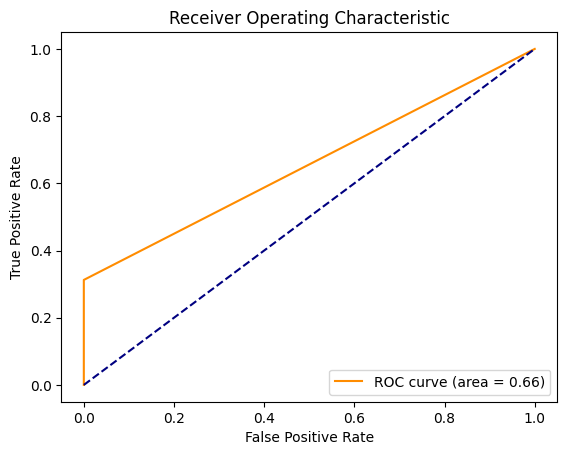

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

# Switch model to evaluation mode
model.eval()

all_labels = []
all_preds = []

test_loader = train_loader  # Use the same DataLoader for testing
# Collect predictions
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix: \n{conf_matrix}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

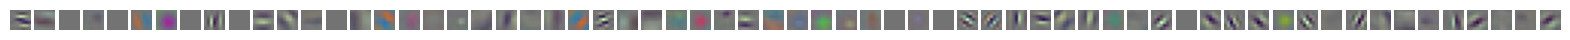

In [25]:
import matplotlib.pyplot as plt

# Function to visualize the filters in the first layer
def visualize_filters(layer):
    filters = layer.weight.data.cpu()  # Get filter weights

    # Normalize filters for display
    filters = (filters - filters.min()) / (filters.max() - filters.min())

    n_filters = filters.shape[0]
    fig, axes = plt.subplots(1, n_filters, figsize=(20, 20))
    
    for i in range(n_filters):
        ax = axes[i]
        ax.imshow(filters[i].permute(1, 2, 0))  # Permute to make the filter visible
        ax.axis('off')

    plt.show()

# Visualize filters in the first conv layer (conv1)
visualize_filters(model.conv1)


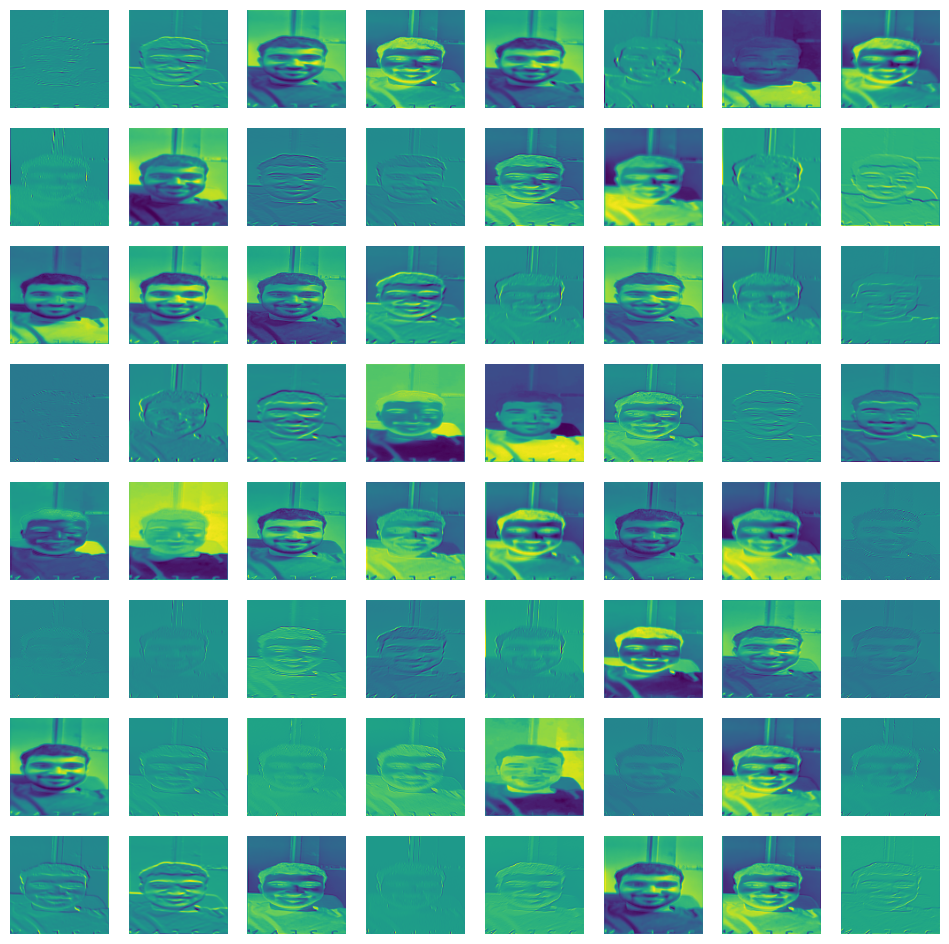

In [26]:
from torchvision import transforms
from PIL import Image
import numpy as np

# Load and preprocess the image
img_path = 'image.jpg'
img = Image.open(img_path)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

input_img = transform(img).unsqueeze(0).to(device)  # Add batch dimension

# Hook function to extract activation maps
activations = []

def get_activation(name):
    def hook(model, input, output):
        activations.append(output.detach().cpu())
    return hook

# Register hook to the first conv layer
model.conv1.register_forward_hook(get_activation('conv1'))

# Forward pass through the model
output = model(input_img)

# Visualize activation maps for conv1
activation = activations[0][0]  # First batch, all filters
fig, axes = plt.subplots(8, 8, figsize=(12, 12))  # Assuming 64 filters in the conv layer

for i, ax in enumerate(axes.flat):
    if i < activation.size(0):
        ax.imshow(activation[i].numpy(), cmap='viridis')
        ax.axis('off')

plt.show()


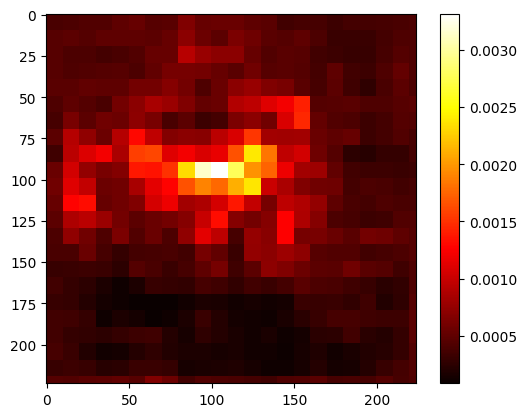

In [27]:
import numpy as np

def occlusion_experiment(model, img, patch_size=30, stride=10):
    img_size = img.size()[2]  # Assuming square images (e.g., 224x224)
    heatmap = np.zeros((img_size, img_size))

    # Loop over the image with the sliding window
    for y in range(0, img_size, stride):
        for x in range(0, img_size, stride):
            occluded_img = img.clone()
            occluded_img[:, :, y:y+patch_size, x:x+patch_size] = 0  # Set patch to zero

            with torch.no_grad():
                output = model(occluded_img.to(device))
                prob = torch.softmax(output, dim=1)[0, 1].item()  # Get probability for class '1' (Arched_Eyebrows)

            heatmap[y:y+patch_size, x:x+patch_size] = prob

    return heatmap

# Perform occlusion experiment
heatmap = occlusion_experiment(model, input_img)

# Visualize the occlusion heatmap
plt.imshow(heatmap, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.show()
